# Detector Plane Computation

## Known Issues

1. **Resolved** I don't understand how the neutrino energy spectrum comes into play in the Lorentz force. [This wiki page](Measurements_of_neutrino_speed) seems to say that above energies of a few eV, neutrinos move at the speed of light. The only place I can think of where energy comes into play with the lorentz force is that the neutrinos would emit B-L radiation since they are bending, which would give us the spectrum we see.

    Resolution: The neutrino spectrum is originating at the sun. It is NOT a result of any process as they traverse from the sun to the Earth. See the wiki page. The sun has a few processes that create neutrinos, and these neutrinos have different energies. This is the spectrum we see at Earth.


2. What is the domininant location and process that gives us the spectrum of neutrinos we see coming from the sun? [This wiki page](https://en.wikipedia.org/wiki/Solar_neutrino#Observed_data) says that the dominant flux **at Earth** of low energy neutrinos comes from PP fusion, and the dominant source of high energy neutrinos comes fro "hep" processes. For now, the neutrino spectrum ranges from $10^{-1} - 10$ MeV. I need the flux **at production.**

3. **Resolved** In calculating the trajectory, the relevant distances are measured in au. The algorithm computes the distance at each point in the trajectory and compares it to 1 au, the distance between the sun and Earth. In the current formulation, we compute the distance until it turns over from $<1$ to $>1$, and then stops. This difference ends up being $\sim10^{-3}$au, which translates to $\sim 10^6$ km. Given the neutrinos are moving at the speed of light, and the magnetic field falls off as 1/r, the amount of bending that occurs over this distance is **hopefully** negligible.

    Resolution: Meeting with Flip on 1/21/22, he said missing Earth by this much isn't such a big deal.

## Changes from !Current_Notebook

1. Function definitions. Just copy-paste all of them into !Current_Notebook

2. Section 1.5.1.1: Reworked code (no deletion) so that we don't scan over initial velocities, only initial positions. All velocities set to 1.

3. Section 1.5.1.2: Reworked code (no deletion) so that we don't scan over initial velocities, only initial positions. All velocities set to 1.

## Intro

Our detector is essentially a photographic plate, so a plane located at $R_{\text{Earth}}$. For clarity, I will refer to this plane as the "detector plane" for the rest of this notebook.

We would like the following:

1. The equation of this plane
2. To know where on this plane do the other trajectories hit 

## The Reasoning

We will be working in the $\vec{B} = B_0 \hat{z}$ limit

1. Pick **one** trajectory and evolove it according to the code. Obtain the location of Earth and the velocity vector at Earth. The velocity vector at Earth defines the normal vector to the detector plane.

For a point $\vec{p} = (p_x, p_y, p_z)$ and a normal vector $\vec{n} = (n_X, n_y, n_z)$, the equation of a plane is given by $$n_xx+n_yy+n_zz - (p_x+ p_y+ p_z) = 0$$

2. Given a list of points from the origin of the sun (a trajectory), call this list $\{\vec{r}\}$. Compute the minimum **two** distances between $\{\vec{r}\}$ and the detector plane. In principle, these two points will be on opposite sides of the detector plane. I believe this will always be the case because our point resolution is not high enough to yield the two closest points on the same side of the plane, but I don't know for certain. Something about the trajectory taking a very sharp turn, which is only visible with high resolution.

Given a point $\vec{p}$ **in** the plane, point $\vec{r}$ in space, and normal vector $\vec{n}$, we can calculate the distance between $\vec{r}$ and the plane, $D$, as: $$D = \frac{(\vec{p}-\vec{r}) \cdot \vec{n}} {|\vec{n}|} = \frac{ n_xr_x+n_yr_y+n_zr_z - d} {|\vec{n}|}$$

3. Make a line between the minimum and next to minimum distance points, and determine where that line intersects the detector plane.



## The Computation

1. Get the set of initial conditions that actually hits Earth.
2. Compute loss on these initial conditions
3. Define the detector plane based on the conditon with minimal loss.
4. For every other trajectory:
 1. Compute the minimum and second minimum distances between each point and the detector plane. These will always be the last and second to last points in the trajectory by algorithm design.
 2. Make a line (continuous function) between these two points
 3. Determine at what location this line intersects the detector plane
 4. Record this location as a "hit"
5. Repeat for all trajectories
6. Plot all "hits" in the detector plane

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import random

import plotly
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline 

print ('Complete')

Complete


In [10]:
rDot = 0.00465047 # in au
rHalf = rDot/2
lightTime = 1 # in Au/C

def sph2Cartesian(rVect):
    '''
    '''
    r = rVect[0]
    theta = rVect[1]
    phi = rVect[2]

    X = r*np.sin(theta)*np.cos(phi)
    Y = r*np.sin(theta)*np.sin(phi)
    Z = r*np.cos(theta)

    return [X,Y,Z]
    
def distance(vect1,vect2):
    ''' 
    vect1 and vect2 must be in cartesian coordinates
    Returns the distance between vect1 and vect2
    '''
    x,y,z = vect1[0],vect1[1],vect1[2]
    x0,y0,z0 = vect2[0],vect2[1],vect2[2]
    return np.sqrt( (x-x0)**2 + (y-y0)**2 +(z-z0)**2 )

def norm(cartesianVector):
    x = cartesianVector[0]
    y = cartesianVector[1]
    z = cartesianVector[2]
    return (np.sqrt(x**2+y**2+z**2))

def km2au(num):
    return num*6.6846e-9

def sec2geVInv(num):
    return 1.52E24* num

def km2geVInv(num):
    return 5.06E18*num

def geVInv2km(num):
    return 5.06E18**-1 * num

def geVInv2au(num):
    return num*5.06*10**13 * 10**-5 *6.6846*10**-9

def au2km(num):
    return num*1.496e+8

def auOverc2min(num):
    return 8.3167464*num 


def rFunction(x,y,z):
    return np.sqrt(x**2+y**2+z**2)


def cosBeta(vec1,vec2):
    ''' 
    Returns cos of the angle between 3-vectors vec1 and vec2
    '''
    x1 = vec1[0]
    y1 = vec1[1]
    z1 = vec1[2]
    x2 = vec2[0]
    y2 = vec2[1]
    z2 = vec2[2]

    numerator = (x1*x2) + (y1*y2) + (z1*z2) 
    denominator = np.sqrt(x1**2 +y1**2 +z1**2) * np.sqrt(x2**2 +y2**2 +z2**2 )
    return (numerator/denominator)


def posAvg(r1,r2):
    ''' 
    Averages two position 3-vectors
    r1 is the initial position 3-vector
    r2 is the final position 3-vector
    '''
    x1 = r1[0]
    y1 = r1[1]
    z1 = r1[2]
    x2 = r2[0]
    y2 = r2[1]
    z2 = r2[2]

    xavg = (x2+x1)/2
    yavg = (y2+y1)/2
    zavg = (z2+z1)/2

    return [xavg,yavg,zavg]


def velocityAvg(r1, r2):
    '''
    Newtonian estimate of the velocity vector between two locations.

    r1 and r2 are both velocity 3-vectors in cartesian

    returns the cartesian 3-velocity 

    eg: vAvgX = x1 + 1/2*(deltaX)
    '''
    x1 = r1[0]
    y1 = r1[1]
    z1 = r1[2]
    x2 = r2[0]
    y2 = r2[1]
    z2 = r2[2]

    deltavX = x2 - x1
    deltavY = y2 - y1
    deltavZ = z2 - z1

    vavgX = x1 + (1/2)*deltavX
    vavgY = y1 + (1/2)*deltavY
    vavgZ = z1 + (1/2)*deltavZ

    return [vavgX,vavgY,vavgZ]


def conditionSph2Car(sphCon,row='Null'):
    '''
    sphCon: one six-dimensional array consisting of [r,theta,phi,vr,vtheta,vphi]
    '''
    r,theta,phi = sphCon[0],sphCon[1],sphCon[2]
    vr,vtheta,vphi = sphCon[3],sphCon[4],sphCon[5]

    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)

    vx = vr*np.sin(theta)*np.cos(phi) + vtheta*r*np.cos(theta)*np.cos(phi) - vphi*r*np.sin(theta)*np.sin(phi)
    vy = vr*np.sin(theta)*np.sin(phi) + vtheta*r*np.cos(theta)*np.sin(phi) + vphi*r*np.sin(theta)*np.cos(phi)
    vz = vr*np.cos(theta)             - vtheta*r*np.sin(theta)

    error = 0.000000001
    assert r-(error*r) <= np.sqrt(x**2 + y**2 + z**2) <= r+(error*r), \
    "Row {0}: Cartesian <-> spherical distance larger than {1}% incorrect".format(row,100*error)
    
    zeroLimit = 1e-15
    if (np.abs(x) <= zeroLimit):
        x=0
    if (np.abs(y) <= zeroLimit):
        y=0
    if (np.abs(z) <= zeroLimit):
        z=0
        
    if (np.abs(vx) <= zeroLimit):
        vx=0
    if (np.abs(vy) <= zeroLimit):
        vy=0
    if (np.abs(vz) <= zeroLimit):
        vz=0
    
    return [x,y,z,vx,vy,vz]


def conditionCar2Sph(carCon,row = 'Null'):
    x,y,z    = carCon[0],carCon[1],carCon[2]
    vx,vy,vz = carCon[3],carCon[4],carCon[5]
    
    r     = np.sqrt(x**2+y**2+z**2)
    theta = np.arctan2(np.sqrt(x**2 + y**2),z) 
    phi   = np.arctan2(y,x)
#     print ('pos',r,theta,phi)
      
    vr     = (x*vx+y*vy+z*vz)/r
    vtheta = 1/np.sin(theta) * z/r**2 * (x*vx+y*vy+z*vz)**(-3/2) -vz/r
    vphi   = (np.cos(theta)/x)**2*(x*vy-y*vx)
#     print('vel',vr,vtheta,vphi)
    
    return [r,theta,phi,vr,vtheta,vphi]
      
    
def Bfield(x,y,z):
    '''
    Returns cartesian components of the B-field at location x,y,z
    
    x,y,z must be in cartesian coordinates measured in Au
    '''
    assert x**2 + y**2 > 0, 'Bfield function, both x & y zero simultaneously'
#  T = 1 kg⋅s−2⋅A−1 = N s / C m = kg / C s 
#    = [mass] / [charge] [time]

    # 3.3 in nT
    Br     = 0
#     Btheta = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
    Btheta = 0
    Bphi   = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
#     Bphi = 0

    # Spherical unit vector decompositions
    # Schematically, we decompose rhat = Axhat + Byhat + Czhat and read off the ABC from wiki
    # The arguments of the ABCs are the cartesian location where we are evaluating the B field
    def A(x,y,z):
        return x/np.sqrt(x**2 +y**2 +z**2)

    def B(x,y,z):
        return y/np.sqrt(x**2 +y**2 +z**2)

    def C(x,y,z):
        return z/np.sqrt(x**2 +y**2 +z**2)

    def D(x,y,z):
        return x*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))

    def E(x,y,z):
        return y*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))
        
    def F(x,y,z): 
        return -(x**2 + y**2) / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2)) 

    def G(x,y,z):
        return -y / np.sqrt(x**2 + y**2)

    def H(x,y,z):
        return x / np.sqrt(x**2 + y**2)

    def I(x,y,z):
        return 0

#     Bx = Br * A(x,y,z) + Btheta * D(x,y,z) + Bphi * G(x,y,z)
#     By = Br * B(x,y,z) + Btheta * E(x,y,z) + Bphi * H(x,y,z)
#     Bz = Br * C(x,y,z) + Btheta * F(x,y,z) + Bphi * I(x,y,z)

    Bx, By, Bz = 0,0,1
#     Bx, By, Bz = 0,0,0

    return (Bx,By,Bz)


def acceleration_normed(vel, pos):
    '''
    Returns acceleration of a unit charge of unit mass with velocity vel at position pos
    '''
    x = pos[0]
    y = pos[1]
    z = pos[2]
    return np.cross(vel,Bfield(x,y,z)) 


def step(pos, vel, acc, dt, q_by_E):
    '''Computes the new position given the old position, velocity, acceleration, and dt
    using the simplest differential equation solver.
    '''
    
    x,y,z = pos[0],pos[1],pos[2]
    

    return next_pos, next_vel, next_acc


def trajectorySolver(initialConditions, q_e, E_MeV, dt):
    '''
    xi = gB-L/q_e

    Inputs:
        initialConditions: array of [r0,v0] in cartesian
        q : the electric charge in units of "e"
        m : the mass/energy of the particle in kg.
        dt: the time increment between each step in Au/c

    Returns:
        trajectory: the 3-vector (x,y,z), the position of the neutrino at each step
        velocity  : the 3-vector (vX,vY,vZ), the velocity of the neutrino at each step
    '''
    r0 = initialConditions[0:3]
    v0 = initialConditions[3:6]

#     assert ((r0[0] != 0) or (r0[1] !=0)), "X and Y initial positions cannot be simultaneously zero. See Jacobian tranformation in the definition of Bfield."
#     assert ((r0[0] != 0) and (r0[1] !=0)), "X and Y initial positions cannot be simultaneously zero. See Jacobian tranformation in the definition of Bfield."

    q_coulombs  = q_e * 1.60217662E10-19  # units of Coulombs
    m_kg  = E_MeV / 5.6095861672249E+29 # units of kilograms
    
#     q_by_E  = q_coulombs/m_kg
    q_by_E  = 1

    # pos = np.array([r0[0],r0[1],r0[2]])
    # vel = np.array([v0[0],v0[1],v0[2]]) 
    pos = np.asarray(r0)
    vel = np.asarray(v0)

#     acc = q_by_E * acceleration_normed(vel, pos)

    xPoints=[] # record of x-values
    yPoints=[] # record of y-values
    zPoints=[] # record of z-values
    vxPoints=[] # record of x-velocities
    vyPoints=[] # record of y-velocities
    vzPoints=[] # record of z-velocities
    

    def dvdt(pos,vel,dt,q_by_E):
        x,y,z = pos[0],pos[1],pos[2]
        return q_by_E*np.cross(vel,Bfield(x,y,z))

    def drdt(pos,vel,dt,q_by_E):
        return vel
    
    

    # Initialize half values
    x_half = pos[0] + 0.5*dt*drdt(pos,vel,dt,q_by_E)[0]
    y_half = pos[1] + 0.5*dt*drdt(pos,vel,dt,q_by_E)[1]
    z_half = pos[2] + 0.5*dt*drdt(pos,vel,dt,q_by_E)[2]
    
    vx_half = vel[0] + 0.5*dt*dvdt(pos,vel,dt,q_by_E)[0]
    vy_half = vel[1] + 0.5*dt*dvdt(pos,vel,dt,q_by_E)[1]
    vz_half = vel[2] + 0.5*dt*dvdt(pos,vel,dt,q_by_E)[2]

    posHalf = [x_half,y_half,z_half]
    velHalf = [vx_half,vy_half,vz_half]
    
    distance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
    
    earthDist = 1.0
    while distance < earthDist:
        
        # Append Points
        xPoints.append(pos[0])
        yPoints.append(pos[1])
        zPoints.append(pos[2])
        velPrecision = 1e-5
#         if (np.abs(1- np.sqrt(vel[0]**2+vel[1]**2+vel[2]**2) ) >= velPrecision ):
#             print ('Velocity normalization outside precision {0}'.format(velPrecision))
#         velNorm = np.sqrt(vel[0]**2 + vel[1]**2 + vel[2]**2)
#         print ('Velocity Normalization', velNorm)
        vxPoints.append(vel[0])
        vyPoints.append(vel[1])
        vzPoints.append(vel[2])
        
        # We put the distance update specifically here so that 
        # we record the last distance that is larger than 1
        distance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
        
        # Leapfrog
        # I actually don't know which of these should come first...
        #     Do we need to update the half positions first    
        pos[0] += dt*drdt(posHalf,velHalf,dt,q_by_E)[0]
        pos[1] += dt*drdt(posHalf,velHalf,dt,q_by_E)[1]
        pos[2] += dt*drdt(posHalf,velHalf,dt,q_by_E)[2]
        vel[0] += dt*dvdt(posHalf,velHalf,dt,q_by_E)[0]
        vel[1] += dt*dvdt(posHalf,velHalf,dt,q_by_E)[1]
        vel[2] += dt*dvdt(posHalf,velHalf,dt,q_by_E)[2] 
        
        posHalf[0] += dt*drdt(pos,vel,dt,q_by_E)[0]
        posHalf[1] += dt*drdt(pos,vel,dt,q_by_E)[1]
        posHalf[2] += dt*drdt(pos,vel,dt,q_by_E)[2]
        velHalf[0] += dt*dvdt(pos,vel,dt,q_by_E)[0]
        velHalf[1] += dt*dvdt(pos,vel,dt,q_by_E)[1]
        velHalf[2] += dt*dvdt(pos,vel,dt,q_by_E)[2]
            
    
    trajectory = [xPoints,yPoints,zPoints]
    velocity   = [vxPoints,vyPoints,vzPoints]

    trajTime = auOverc2min(len(trajectory[0])*dt)

#     assert(trajTime > auOverc2min(lightTime)), "Trajectory Time: {0} min. Neutrino is moving faster than light.".format(trajTime)
    if (trajTime < auOverc2min(lightTime)):
        print ('WARNING: neutrino moving faster than light. Change dt')
        print ('Current dt: ',dt)
#     if (len(trajectory[0]) <= 2):
#         print ('WARNING: only two data points in the trajectory. Decrease dt')
#         print ('Current dt: ',dt)

    return (trajectory,velocity)


def sphDF2CarDF(dataDFSph):
    columns = ['x','y','z','vx','vy','vz','L','cosBeta']
    dataDFCar = pd.DataFrame(columns=columns)
    
    for row in np.arange(0,dataDFSph.shape[0]):
        sphCon = np.asarray(dataDFSph.iloc[int(row)][0:6])
        
        L = dataDFSph.iloc[int(row)][-2]
        cosBeta = dataDFSph.iloc[int(row)][-1]
        
        carCon = conditionSph2Car(sphCon,row)

        x = carCon[0]
        y = carCon[1]
        z = carCon[2]
        zeroLimit = 1e-16
#         if (x <= zeroLimit):
#             x=0
#         if (y <= zeroLimit):
#             y=0
#         if (z <= zeroLimit):
#             z=0
        vx = carCon[0]
        vy = carCon[1]
        vz = carCon[2]

        appendThis = ({'x':x,'y':y,'z':z,'vx':vx,'vy':vy,'vz':vz,'L':L,'cosBeta':cosBeta})
        dataDFCar = dataDFCar.append(appendThis,ignore_index=True)
    return dataDFCar


def lossFunction(trajectorySolverOutput):
    '''
    This breaks for vmax 3 digits and larger
    vmax = 99 is fine, but vmax = 100 breaks this function
    '''
    positions = trajectorySolverOutput[0]
    zlocations = positions[2]
    zLoss = (zlocations[-1] + zlocations[-2]) * 0.5
    return zLoss


def endingAngle(trajectorySolverOutput):
    positions   = trajectorySolverOutput[0]
    velocities  = trajectorySolverOutput[1]
    x,y,z       = positions[0],positions[1],positions[2]
    vx,vy,vz    = velocities[0],velocities[1],velocities[2]
    lastPos     = [x[-1],y[-1],z[-1]]
    nextlastPos = [x[-2],y[-2],z[-2]]
    avgPos      = np.asarray(posAvg(nextlastPos,lastPos))
    lastVel     = [vx[-1],vy[-1],vz[-1]]
    nextlastVel = [vx[-2],vy[-2],vz[-2]]
    avgVel      = np.asarray(velocityAvg(lastVel,nextlastVel))
        
    return cosBeta(avgVel,avgPos)


def computeLossAndBeta(dataDFSph,q,m,dt):
    for row in np.arange(0,(dataDFSph.shape[0])):
        ICSph = np.asarray(dataDFSph.iloc[row][0:6])
        ICCar = conditionSph2Car(ICSph,row)
            
        output = trajectorySolver(ICCar,q,m,dt)
        
        loss = lossFunction(output)
        cosBeta = endingAngle(output)        

        dataDFSph.iloc[row]['L'] = loss
        dataDFSph.iloc[row]['cosBeta'] = cosBeta
    return dataDFSph


def determineDetectorPlane(dataDFSph,q,m,dt,rHatPerp = True):
    '''
    Input:
        dataDFSph: The initial condition data frame in spherical coordinates. 
                   This function converts to cartesian 
        q,m,dt   : The usual conditions required to evolve trajectories
        
    Returns:
        planePos: a point in space within the plane in cartesian
        planeVel: the unnormalized normal vector for the plane in cartesian
        
        
    rHatPerp: This option sets the normal of the plane to the -rhat direction and also
              assigns to each initial velocity, the velocity of the condition used
              to determine the plane. All initial velocities should point in the same
              direction.
    '''
    dataDFSph  = computeLossAndBeta(dataDFSph,q,m,dt)
    planeConditionSph   = np.asarray(dataDFSph.iloc[0])
    planeConditionCar   = conditionSph2Car(planeConditionSph)
    output              = trajectorySolver(planeConditionCar,q,m,dt)
    planeTraj, planeVel = output[0], output[1]
    
    r1 = np.transpose(planeTraj)[-1]
    r2 = np.transpose(planeTraj)[-2]    
    
    v1 = np.transpose(planeVel)[-1]
    v2 = np.transpose(planeVel)[-2]
    
    planePos = posAvg(r2,r1)
    auLimit = 0.01
    if np.abs(norm(planePos)) >= auLimit:
        print ('WARNING: Plane distance larger than {:.2e} km away from earth'.format(au2km(auLimit)))
        print ('Plane distance: {0} au'.format(norm(planePos)))

    planeVel = velocityAvg(r2,r1)
    
    # This defines the normal of the plane to be pointing back to the
    # origin from the point that defines the location of the plane.
    if rHatPerp:
        planeVel = np.multiply(-1,planePos)
        sphCon = planeConditionSph[0:6]
        return (planePos,planeVel,sphCon)
    
    return (planePos,planeVel)


def planeDistance(Spoint,Ppoint,Pnorm):
    '''
    Spoint: An arbitrary point in space
    Ppoint: A point on the plane
    Pnorm : The normal vector of the plane
    Note  : All points must be in cartesian
    
    Returns the perpindicular distance between Spoint and the plane
    Note: We leave the distance "signed" in order to make the computation easier 
    '''
    numerator   = (np.dot(Spoint,Pnorm)-np.dot(Ppoint,Pnorm))
    denominator = np.dot(Pnorm,Pnorm)**0.5
    return numerator/denominator


def planeLineIntersection(line,plane):
    '''
    Inputs are tuples of vectors
    
    line: [point1, point2], line starts at r1 and ends at r2 in cartesian
    plane: [point, normal], plane parameters in cartesian
    '''
    
    p0 = np.asarray(plane[0])
    n  = np.asarray(plane[1])
    r1 = np.asarray(line[0])
    r2 = np.asarray(line[1])
    
    numerator = (np.dot(n,p0))-(np.dot(n,r1))
    denominator = (np.dot(n,(r2-r1)))
    
    tStar = numerator / denominator
    intersection = r1 + tStar*(r2-r1)
    return (intersection)


def trajectoryHit(InitialCondition,plane,q,m,dt,cartesian = True):
    '''
    InitialCondition must be given in spherical coordinates. 
    It is then converted to cartesian within this function.
    
    plane: tuple of [p0,n], the point and normal of the plane
    '''
    
    if not cartesian:
        carCon = conditionSph2Car(InitialCondition)
    
    if cartesian:
        carCon = InitialCondition
        
    output = trajectorySolver(carCon,q,m,dt)
    traj, vel = np.asarray(output[0]),np.asarray(output[1])
        
    r1 = np.transpose(traj)[-2] # Line starts at r1
    r2 = np.transpose(traj)[-1] # and ends at r2
        
    line = [r1,r2]
    
    p0 = plane[0]
    n  = plane[1]
    
    hitPoint = planeLineIntersection(line,plane)
    return hitPoint


def planeHitCheck(plane,point):
    '''
    This function ensures that the point is actually contained in the plane.
    
    Plane: Tuple of [point,normal] in cartesian
    Point: 3-vector of [x,y,z] in cartesian
    
    Returns: None
    If any point is NOT contained within the plane, this will trigger an assertion error
    '''
    p0 = plane[0]
    n  = plane[1]
    hitCondition = np.dot(n,(point-p0))
    assert hitCondition <= 1e-14, "Trajectory doesn't hit plane within error."
    return None


class itterativeDict(dict):
    def __init__(self):
        self = dict()
        
    def update(self,key,value):
        self[key] = value


        
def makeInitialConditions(numConditions):
    rHalf = rDot/2
    positionRange = np.arange(0,numConditions)

    columns = ['r','theta','phi','vr','vTheta','vPhi','L','cosBeta']
    dataDFSph = pd.DataFrame(columns=columns)

    vr = 1
    v1 = [vr,0,0]

    for i in positionRange:

        randPhi = random()*2*np.pi
        randTheta = random()*np.pi

        p1 = [rHalf,randTheta,randPhi]

        initialCondition = np.concatenate((p1,v1))

        r      = p1[0]
        theta  = p1[1]
        phi    = p1[2]
        vr     = v1[0]
        vtheta = v1[1]
        vphi   = v1[2]

        appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi,'L':0,'cosBeta':0})
#         appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi})
        dataDFSph = dataDFSph.append(appendThis,ignore_index=True)

    return dataDFSph



def updateVelocities(dataDFSph2,planeCon):
    carCon = conditionSph2Car(planeCon)
    dataDFCar2 = sphDF2CarDF(dataDFSph2)

    dataDFCar2.vx = carCon[3]
    dataDFCar2.vy = carCon[4]
    dataDFCar2.vz = carCon[5]
    return dataDFCar2



def getPlaneHits(dataDFCar2,q,E,dt,cartesian = True):
    hitVector = []
    for row in np.arange(0,(dataDFCar2.shape[0])):
        ICCar = np.asarray(dataDFCar2.iloc[row][0:6]) 
        
        if type(E) != int:
            E = np.mean(E)
        
        planePos, planeVel, planeCon =  determineDetectorPlane(dataDFSph2,q,E,dt,True)
        plane = [planePos,planeVel]
        
        hitLocation = trajectoryHit(ICCar,plane,q,E,dt,cartesian = True)
        planeHitCheck(plane,hitLocation)
        hitVector.append(hitLocation) 
        return hitVector

print ('Complete')

Complete


### Debug Section

----------------------

In [33]:
def conditionSph2Car(sphCon,row='Null'):
    '''
    vel and pos are in spherical coordinates 
    '''
    r,theta,phi = sphCon[0],sphCon[1],sphCon[2]
    vr,vtheta,vphi = sphCon[3],sphCon[4],sphCon[5]

    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    
    vx = vr*np.sin(theta)*np.cos(phi)
    vy = vr*np.sin(theta)*np.sin(phi)
    vz = vr*np.cos(theta)

    error = 0.000000001
    assert r-(error*r) <= np.sqrt(x**2 + y**2 + z**2) <= r+(error*r), \
    "Row {0}: Cartesian <-> spherical distance larger than {1}% incorrect".format(row,100*error)
    
    zeroLimit = 1e-15
    if (np.abs(x) <= zeroLimit):
        x=0
    if (np.abs(y) <= zeroLimit):
        y=0
    if (np.abs(z) <= zeroLimit):
        z=0
        
    if (np.abs(vx) <= zeroLimit):
        vx=0
    if (np.abs(vy) <= zeroLimit):
        vy=0
    if (np.abs(vz) <= zeroLimit):
        vz=0
    
    return [x,y,z,vx,vy,vz]


def Bfield(x,y,z):
    '''
    Returns cartesian components of the B-field at location x,y,z
    
    x,y,z must be in cartesian coordinates measured in Au'''
    
    assert ((x != 0) or (y !=0)), "X and Y initial positions cannot be simultaneously zero. See Jacobian tranformation in the definition of Bfield."

#  T = 1 kg⋅s−2⋅A−1 = N s / C m = kg / C s 
#    = [mass] / [charge] [time]

    # 3.3 in nT
    Br     = 0
    Btheta = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
#     Bphi   = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
    Bphi = 0

    # Spherical unit vector decompositions
    # Schematically, we decompose rhat = Axhat + Byhat + Czhat and read off the ABC from wiki
    # The arguments of the ABCs are the cartesian location where we are evaluating the B field
    def A(x,y,z):
        return x/np.sqrt(x**2 +y**2 +z**2)

    def B(x,y,z):
        return y/np.sqrt(x**2 +y**2 +z**2)

    def C(x,y,z):
        return z/np.sqrt(x**2 +y**2 +z**2)

    def D(x,y,z):
        return x*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))

    def E(x,y,z):
        return y*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))
        
    def F(x,y,z): 
        return -(x**2 + y**2) / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2)) 

    def G(x,y,z):
        return -y / np.sqrt(x**2 + y**2)

    def H(x,y,z):
        return x / np.sqrt(x**2 + y**2)

    def I(x,y,z):
        return 0

#     Bx = Br * A(x,y,z) + Btheta * D(x,y,z) + Bphi * G(x,y,z)
#     By = Br * B(x,y,z) + Btheta * E(x,y,z) + Bphi * H(x,y,z)
#     Bz = Br * C(x,y,z) + Btheta * F(x,y,z) + Bphi * I(x,y,z)

#     Bx, By, Bz = 0,0,1
    Bx, By, Bz = 0,0,0

    return (Bx,By,Bz)


def trajectorySolver(initialConditions, q_e, m_MeV, dt):
    '''
    xi = gB-L/q_e

    Inputs:
        initialConditions: array of [r0,v0] in cartesian
        q : the electric charge in units of "e"
        m : the mass/energy of the particle in kg.
        dt: the time increment between each step in Au/c

    Returns:
        trajectory: the 3-vector (x,y,z), the position of the neutrino at each step
        velocity  : the 3-vector (vX,vY,vZ), the velocity of the neutrino at each step
    '''
    r0 = initialConditions[0:3]
    v0 = initialConditions[3:6]

    q_coulombs  = q_e * 1.60217662E10-19  # units of Coulombs
    m_kg  = m_MeV / 5.6095861672249E+29 # units of kilograms
    
#     q_by_m  = q_coulombs/m_kg
    q_by_m  = 1

    # pos = np.array([r0[0],r0[1],r0[2]])
    # vel = np.array([v0[0],v0[1],v0[2]]) 
    pos = np.asarray(r0)
    vel = np.asarray(v0)

#     acc = q_by_m * acceleration_normed(vel, pos)

    xPoints=[] # record of x-values
    yPoints=[] # record of y-values
    zPoints=[] # record of z-values
    vxPoints=[] # record of x-velocities
    vyPoints=[] # record of y-velocities
    vzPoints=[] # record of z-velocities
    

    def dvdt(pos,vel,dt,q_by_m):
        x,y,z = pos[0],pos[1],pos[2]
        return q_by_m*np.cross(vel,Bfield(x,y,z))

    def drdt(pos,vel,dt,q_by_m):
        return vel
    
    

    # Initialize half values
    x_half = pos[0] + 0.5*dt*drdt(pos,vel,dt,q_by_m)[0]
    y_half = pos[1] + 0.5*dt*drdt(pos,vel,dt,q_by_m)[1]
    z_half = pos[2] + 0.5*dt*drdt(pos,vel,dt,q_by_m)[2]
    
    vx_half = vel[0] + 0.5*dt*dvdt(pos,vel,dt,q_by_m)[0]
    vy_half = vel[1] + 0.5*dt*dvdt(pos,vel,dt,q_by_m)[1]
    vz_half = vel[2] + 0.5*dt*dvdt(pos,vel,dt,q_by_m)[2]

    posHalf = [x_half,y_half,z_half]
    velHalf = [vx_half,vy_half,vz_half]
    
    distance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
    earthDist = 1
    
    while distance < earthDist:
        
#     for i in range(0,1):
#         print ('------------------------')
#         print ('Step: ', i)

        # Append Points
        xPoints.append(pos[0])
        yPoints.append(pos[1])
        zPoints.append(pos[2])
        vxPoints.append(vel[0])
        vyPoints.append(vel[1])
        vzPoints.append(vel[2])
        
        # Leapfrog
        pos[0] += dt*drdt(posHalf,velHalf,dt,q_by_m)[0]
        pos[1] += dt*drdt(posHalf,velHalf,dt,q_by_m)[1]
        pos[2] += dt*drdt(posHalf,velHalf,dt,q_by_m)[2]
        vel[0] += dt*dvdt(posHalf,velHalf,dt,q_by_m)[0]
        vel[1] += dt*dvdt(posHalf,velHalf,dt,q_by_m)[1]
        vel[2] += dt*dvdt(posHalf,velHalf,dt,q_by_m)[2]
          
        
        posHalf[0] += dt*drdt(pos,vel,dt,q_by_m)[0]
        posHalf[1] += dt*drdt(pos,vel,dt,q_by_m)[1]
        posHalf[2] += dt*drdt(pos,vel,dt,q_by_m)[2]
        velHalf[0] += dt*dvdt(pos,vel,dt,q_by_m)[0]
        velHalf[1] += dt*dvdt(pos,vel,dt,q_by_m)[1]
        velHalf[2] += dt*dvdt(pos,vel,dt,q_by_m)[2]
    
        distance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
    
    trajectory = [xPoints,yPoints,zPoints]
    velocity   = [vxPoints,vyPoints,vzPoints]

    trajTime = auOverc2min(len(trajectory[0])*dt)

#     assert(trajTime > auOverc2min(lightTime)), "Trajectory Time: {0} min. Neutrino is moving faster than light.".format(trajTime)
    if (trajTime < auOverc2min(lightTime)):
        print ('WARNING: neutrino moving faster than light. Change dt')
        print ('Current dt: ',dt)
        
    if (len(trajectory[0]) <= 2):
        print ('WARNING: only two data points in the trajectory. Decrease dt')
        print ('Current dt: ',dt)

    return (trajectory,velocity)

In [40]:
q,m = 1,1
dt = 0.01

carRow = (rDot/2,np.pi/2,np.pi,1,0,0)
sphRow = conditionSph2Car(carRow)
traj,vel = trajectorySolver(sphRow,q,m,dt)

print (len(traj[0]))

[-0.002325235, 0, 0]
[-1.0, 0, 0]
posHalf_Initial:  [-0.007325235, 0.0, 0.0]
velHalf_Initial:  [-1.0, 0.0, 0.0]
100


-----------------------

## Purely Radial Velocities

### Radial Initial Conditions, Compute Loss and Beta

In [73]:
q,m,dt = 1,1,0.01

numPositions = 150

rHalf = rDot/2

positionRange = np.arange(0,numPositions)

columns = ['r','theta','phi','vr','vTheta','vPhi','L','cosBeta']
dataDFSph = pd.DataFrame(columns=columns)

vr = 1
v1 = [vr,0,0]

for i in positionRange:

    randPhi = random()*2*np.pi
    randTheta = random()*np.pi

    p1 = [rHalf,randTheta,randPhi]

    initialCondition = np.concatenate((p1,v1))

    r      = p1[0]
    theta  = p1[1]
    phi    = p1[2]
    vr     = v1[0]
    vtheta = v1[1]
    vphi   = v1[2]

    appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi,'L':0,'cosBeta':0})
    dataDFSph = dataDFSph.append(appendThis,ignore_index=True)

print ('{0} Initial Conditions'.format(dataDFSph.shape[0]))

dataDFSph = computeLossAndBeta(dataDFSph,q,m,dt)
print (dataDFSph.head(5))
print ('Complete')

150 Initial Conditions
          r     theta       phi   vr  vTheta  vPhi         L  cosBeta
0  0.002325  1.075601  6.117935  1.0     0.0   0.0  0.473932      1.0
1  0.002325  2.179460  3.886870  1.0     0.0   0.0 -0.570242      1.0
2  0.002325  2.012632  3.560607  1.0     0.0   0.0 -0.426456      1.0
3  0.002325  0.030098  5.921584  1.0     0.0   0.0  0.996874      1.0
4  0.002325  2.772475  0.912443  1.0     0.0   0.0 -0.930151      1.0
Complete


### Minimize Loss, Get New Conditions, Compute new Loss and Beta

In [74]:
lossList  = np.abs(dataDFSph.L)
lossLimit = min(lossList)
dataDFSph1 = dataDFSph.loc[(np.abs(dataDFSph['L']) <=  lossLimit)]

# theta = np.pi/2
theta = dataDFSph1.theta
# phi = 0
phi   = dataDFSph1.phi

margin = 0.001
# deltaTheta = 0
deltaTheta = margin*np.pi/2
# deltaPhi = 0
deltaPhi = margin*(2*np.pi)/2

columns = ['r','theta','phi','vr','vTheta','vPhi','L','cosBeta']
dataDFSph2 = pd.DataFrame(columns=columns)

v1 = [1,0,0]

for i in positionRange:
    randTheta = float(np.random.uniform((theta-deltaTheta),(theta+deltaTheta)))
    randPhi   = float(np.random.uniform((phi-deltaPhi),(phi+deltaPhi)))
    p1 = [rHalf,randTheta,randPhi]

    initialCondition = np.concatenate((p1,v1))

    r      = p1[0]
    theta  = p1[1]
    phi    = p1[2]
    vr     = v1[0]
    vtheta = v1[1]
    vphi   = v1[2]

    appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi,'L':0,'cosBeta':0})
    dataDFSph2 = dataDFSph2.append(appendThis,ignore_index=True)

dataDFSph2 = computeLossAndBeta(dataDFSph2,q,m,dt)
print (dataDFSph2.head(5))
# print (dataDFSph2)
print ('Complete')

          r     theta       phi   vr  vTheta  vPhi         L  cosBeta
0  0.002325  1.573303  3.906547  1.0     0.0   0.0 -0.002500      1.0
1  0.002325  1.572042  3.909362  1.0     0.0   0.0 -0.001242      1.0
2  0.002325  1.571634  3.906405  1.0     0.0   0.0 -0.000836      1.0
3  0.002325  1.571135  3.908764  1.0     0.0   0.0 -0.000337      1.0
4  0.002325  1.571992  3.906878  1.0     0.0   0.0 -0.001192      1.0
Complete


### Plot Initial Conditions

In [75]:
dataDFCar = sphDF2CarDF(dataDFSph2)
x,y,z = dataDFCar.x,dataDFCar.y,dataDFCar.z
loss = dataDFCar.L
vx,vy,vz = dataDFCar.vx,dataDFCar.vy,dataDFCar.vz

fig1 = go.Figure(data=go.Cone(
    x=x, 
    y=y, 
    z=z, 
    u=vx, 
    v=vy, 
    w=vz))

## Add the intial position markers
fig1.add_trace(
    go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode = 'markers',
            marker=dict(
            size=3,
            color = z,
            colorscale='Viridis'
                )
            )
)

# Add the location of the sun
fig1.add_trace(
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode = 'markers',
        marker = dict(
            size = 6,
            color = 'orange')
                )
            )

fig1.show()

### B=0 debug Check

Double check that for each initial condition, every single z location along a trajectory is identically zero.

If this works, it should run with no error.
If this fails, an assertion should trigger and output the row(condition) and step at which z is not zero.

In [247]:
for row in range(0,dataDFSph2.shape[0]):
    conditionSph = np.asarray(dataDFSph2.iloc[row][:-2])
    conditionCar = conditionSph2Car(conditionSph)

    output = trajectorySolver(conditionCar,q,m,dt)
    xVect = output[0][0]
    yVect = output[0][1]
    zVect = output[0][2]
    vxVect = output[1][0]
    vyVect = output[1][1]
    vzVect = output[1][2]

    posLimit = 1e-10
    velLimit = 1e-10
    for i in range(0,len(zVect)):
        x = xVect[i]
        y = yVect[i]
        z = zVect[i]
#         distance = np.sqrt(x**2+y**2+z**2)
#         assert (1-posLimit <= distance <= 1+posLimit),'{0}'.format(distance)
        assert (z==0),'z not equal to 0 in this (row,step): {0,1}'.format(row,i)
    
        vx = vxVect[i]
        vy = vyVect[i]
        vz = vzVect[i]
        assert (1-1e-8 <= np.sqrt(vx**2+vy**2+vz**2) <= 1+1e-8), 'Velocity norm is not 1 in (row,step): {0,1}'.format(row,i)

print ('Complete')

Complete


### Plot a single Trajectory

In [76]:
row = 15

conditionSph = np.asarray(dataDFSph2.iloc[row][:-2])
conditionCar = conditionSph2Car(conditionSph)
output = trajectorySolver(conditionCar,q,m,dt)
trajectory = output[0]
velocity   = output[1]

x,y,z = trajectory[0],trajectory[1],trajectory[2]

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode = 'markers',
    marker=dict(
        size=2,
        color = z,
        colorscale='Viridis'
    )
)

data1 = [trace1]
fig1 = go.Figure(data=data1)
fig1.update_layout(
    scene = dict(
        zaxis = dict(range=[-10*max(z),10*max(z)])
    )
)

fig1.add_trace(
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode = 'markers',
        marker = dict(
            size = 6,
            color = 'orange')
                )
            )
offline.iplot(fig1, filename='simple-3d-scatter')

print ('Complete')

Complete


### Determine Detector Plane and Hit Locations

In [77]:
plane = determineDetectorPlane(dataDFSph2,q,m,dt,rHatPerp = True) 

hitVector = []
for row in np.arange(0,(dataDFSph2.shape[0])):
    ICSph = np.asarray(dataDFSph2.iloc[row][:-2]) 
    hitLocation = trajectoryHit(ICSph,plane,q,m,dt)
    hitVector.append(hitLocation)


print ('Complete')

Plane distance: 0.9973252350000004 au
Complete


### Plot Hits on the Detector Plane

In [78]:
hitVectorT = np.asarray(np.transpose(hitVector))
x,y,z = hitVectorT[0],hitVectorT[1],hitVectorT[2]
# fig1.add_trace(
#     go.Figure(data=go.Cone(
#     x=[plane[0][0]], 
#     y=[plane[0][1]], 
#     z=[plane[0][2]], 
#     u=[plane[1][0]], 
#     v=[plane[1][1]], 
#     w=[plane[1][2]])
#                 ))
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode = 'markers',
    marker=dict(
        size=2,
        color = z,
        colorscale='Viridis'
    )
)

data1 = [trace1]
fig1 = go.Figure(data=data1)


fig1.add_trace(
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode = 'markers',
        marker = dict(
            size = 6,
            color = 'orange')
    )
)

fig1.show()
# offline.iplot(fig1, filename='simple-3d-scatter')

------------------

## Non-radial Velocities

### "Minimizing Loss"

We need to think a little more carefully about what it means to minimize the loss now that we have nonradial velocities. 

For $\vec{B} = 0$ or constant, minimizing loss meant evolving the trajectory until the particle was 1au away from the sun and subtracting its ending z-location from $z=0$, the presumed z-location of Earth. With a nonzero B, this should still hold true no? What will change is the patch of the sun whose neutrinos actually hit Earth, but minimizing loss still equates to "hitting Earth."

### A Helpful Picture

We now move onto addressing the directions that hit Earth that are **not** in the radial direction. These are represented by the points $\vec{r_A}$ and $\vec{r_B}$ in the following picture.

The algorithm is the following:

1. Set the magnetic field to the full Parker model.
2. For purely **radial** initial conditions, determine the one that minimizes loss. This condition defines the Earth plane, $\vec{p_0}$ and $\vec{n_0}$. We will call this trajectory the "plane trajectory" since it defined the Earth plane.
3. For the nonradial conditions we have at least two approaches:
    1. A "nearby" point to the "plane trajectory" should have roughly the same direction as the plane direction. In the picture below, the plane trajectory is $(\vec{r_B},\vec{v_B})$ so a nearby point should have an initial condition $(\vec{r_A},\vec{v_B} + \delta \vec{v})$. We determine $\delta \vec{V}$ by taking a small cone of velocities centered at $\vec{v_B}$.
   
    2. Another way is to take the straight connecting the two points $\vec{r_A}$ and $\vec{p_0}$ and take that to be the center of our cone of velocities.
    
After discussing with Filp, we think the best approach is to make the detector plane perpindicular to the $\hat{r}$ direction always. To find the direction of the other trajectories, we parallel transport the velocity from the trajectory that defiend the plane onto the other two points and evolve a cone around them.

![title](SunPlaneFormulation.png)

### The Algorithm

1. Make the 3 points on the belt of the sun
2. Determine the detector plane
3. Parallel transport the velocity from the plane trajectory to the other two points (all points)on the belt

4. Generate a cone of trajectories at each point
5. Evolve each trajectory and check that $\beta \leq 30^\circ$ 

### Initialize Dataframe

In [11]:
q,E,dt = 1,1,0.01

dataDFSph = makeInitialConditions(100)
print ('{0} Initial Conditions'.format(dataDFSph.shape[0]))

dataDFSph = computeLossAndBeta(dataDFSph,q,E,dt)
print (dataDFSph.head(5))
print ('Complete')

100 Initial Conditions
          r     theta       phi   vr  vTheta  vPhi         L   cosBeta
0  0.002325  2.464904  3.239471  1.0     0.0   0.0 -0.793158  0.951447
1  0.002325  2.065233  5.920407  1.0     0.0   0.0 -0.492248  0.898985
2  0.002325  0.212034  1.349871  1.0     0.0   0.0  0.974990  0.994783
3  0.002325  2.139458  3.941638  1.0     0.0   0.0 -0.553219  0.909376
4  0.002325  0.373138  3.008705  1.0     0.0   0.0  0.938009  0.983999
Complete


### Minimize loss, generate new Dataframe

In [12]:
lossList  = np.abs(dataDFSph.L)
lossLimit = min(lossList)
minLossCondition = dataDFSph.loc[(np.abs(dataDFSph['L']) <=  lossLimit)]

columns = ['r','theta','phi','vr','vTheta','vPhi','L','cosBeta']
dataDFSph2 = pd.DataFrame(columns=columns)
v1 = [1,0,0]

# margin = 1e-8
margin = 1/8
# deltaTheta = (margin*(np.pi/2))
deltaTheta = 0
deltaPhi = margin*2*np.pi/2
# deltaPhi = 0

for i in range(0,len(dataDFSph.index)):
#     phi = float(minLossCondition.phi)
    phi = 0
#     theta = float(minLossCondition.theta)
    theta = np.pi/2
    
    randTheta = np.random.uniform( (theta-deltaTheta), (theta+deltaTheta) )
    randPhi   = np.random.uniform( (phi-deltaPhi), (phi+deltaPhi) )
    p1 = [rHalf,randTheta,randPhi]

    r      = p1[0]
    theta  = p1[1]
    phi    = p1[2]
    vr     = v1[0]
    vtheta = v1[1]
    vphi   = v1[2]

    appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi,'L':0,'cosBeta':0})
#     appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi})

    dataDFSph2 = dataDFSph2.append(appendThis,ignore_index=True)
    
# dataDFSph2 = computeLossAndBeta(dataDFSph2,q,m,dt)
print (dataDFSph2.head(5))
print ('Complete')

          r     theta       phi   vr  vTheta  vPhi    L  cosBeta
0  0.002325  1.570796 -0.375477  1.0     0.0   0.0  0.0      0.0
1  0.002325  1.570796 -0.110395  1.0     0.0   0.0  0.0      0.0
2  0.002325  1.570796  0.293699  1.0     0.0   0.0  0.0      0.0
3  0.002325  1.570796 -0.274894  1.0     0.0   0.0  0.0      0.0
4  0.002325  1.570796 -0.123857  1.0     0.0   0.0  0.0      0.0
Complete


### Plot Initial Conditions

In [13]:
dataDFCar = sphDF2CarDF(dataDFSph2)
x,y,z = dataDFCar.x,dataDFCar.y,dataDFCar.z
loss = dataDFCar.L
vx,vy,vz = dataDFCar.vx,dataDFCar.vy,dataDFCar.vz

# Trajectories
fig1 = go.Figure(data=go.Cone(
    x=x, 
    y=y, 
    z=z, 
    u=vx, 
    v=vy, 
    w=vz,
#     sizemode = 'absolute',
sizeref = 10
))

# Add the location of the sun
fig1.add_trace(
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode = 'markers',
        marker = dict(
            size = 6,
            color = 'orange')
                )
            )

fig1.show()

### Determine Detector Plane

In [14]:
planePos, planeVel, planeCon =  determineDetectorPlane(dataDFSph2,q,E,dt,True)
plane = [planePos,planeVel]
print ('Location,normal',plane[0],plane[1])
print ('Condition (Spherical)',planeCon)
print ('Complete')

Plane distance: 1.0001188189330952 au
Location,normal [0.6241686857899362, -0.7814416828294951, 0.0] [-0.62416869  0.78144168 -0.        ]
Condition (Spherical) [ 0.00232524  1.57079633 -0.37547684  1.          0.          0.        ]
Complete


### Plot condition corresponding to Plane

In [15]:
planeConCar = conditionSph2Car(planeCon)

# Plot the plane condition
fig1 =go.Figure(data=go.Cone(
    x=[planeConCar[0]], 
    y=[planeConCar[1]], 
    z=[planeConCar[2]], 
    u=[planeConCar[3]], 
    v=[planeConCar[4]], 
    w=[planeConCar[5]],
sizeref = 0.1
))

fig1.add_trace(
    go.Cone(
    x = [planePos[0]],
    y = [planePos[1]],
    z = [planePos[2]],
    u = [planeVel[0]],
    v = [planeVel[1]],
    w = [planeVel[2]],
sizeref = 0.1
    ))

fig1.add_trace(
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'orange')
                )
            )

fig1.show()

### Assign all vectors the Initial Velocity of the plane condition

In [16]:
dataDFCar2 = updateVelocities(dataDFSph2,planeCon)

print (dataDFCar2.head(5))

          x         y    z        vx        vy  vz    L   cosBeta
0  0.002163 -0.000853  0.0  0.930333 -0.366716   0  0.0  0.865994
1  0.002311 -0.000256  0.0  0.930333 -0.366716   0  0.0  0.865994
2  0.002226  0.000673  0.0  0.930333 -0.366716   0  0.0  0.865994
3  0.002238 -0.000631  0.0  0.930333 -0.366716   0  0.0  0.865994
4  0.002307 -0.000287  0.0  0.930333 -0.366716   0  0.0  0.865994


### Plot Initial Conditions and plane condition

Double check that all conditions (smaller cones) are parallel to the plane condition (larger cone)

In [21]:
x,y,z = dataDFCar2.x,dataDFCar2.y,dataDFCar2.z
loss = dataDFCar2.L
vx,vy,vz = dataDFCar2.vx,dataDFCar2.vy,dataDFCar2.vz

planeConCar = conditionSph2Car(planeCon)

refSize = 0.0001

# Plot IC's
fig1 = go.Figure(data=go.Cone(
    x=x, 
    y=y, 
    z=z, 
    u=vx, 
    v=vy, 
    w=vz,
    sizeref = 25*4
))

# Add the condition of the plane
fig1.add_trace(
    go.Cone(
    x = [planeConCar[0]],
    y = [planeConCar[1]],
    z = [planeConCar[2]],
    u = [planeConCar[3]],
    v = [planeConCar[4]],
    w = [planeConCar[5]],
sizeref = 2*refSize
    ))


# Add the intial position markers
fig1.add_trace(
    go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode = 'markers',
            marker=dict(
            size=3,
            color = z,
            colorscale='Viridis'
                )
            )
)

# Add the location of the sun
fig1.add_trace(
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode = 'markers',
        marker = dict(
            size = 6,
            color = 'orange')
                )
            )

fig1.show()

### Plot plane condition and plane location

Double check that plane points back to sun in the $-\hat{r}$ direction

In [22]:
# Add the condition of the plane
fig1 = go.Figure(data=go.Cone(
    x = [planeConCar[0]],
    y = [planeConCar[1]],
    z = [planeConCar[2]],
    u = [planeConCar[3]],
    v = [planeConCar[4]],
    w = [planeConCar[5]],
sizeref = 0.15
))


# Add the location of the plane
fig1.add_trace(
    go.Cone(
    x = [planePos[0]],
    y = [planePos[1]],
    z = [planePos[2]],
    u = [planeVel[0]],
    v = [planeVel[1]],
    w = [planeVel[2]],
sizeref = 0.15
    ))


# Add the location of the sun
fig1.add_trace(
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode = 'markers',
        marker = dict(
            size = 8,
            color = 'orange')
                )
            )


fig1.show()

### Determine Plane Hits

In [23]:
hitVector = []
for row in np.arange(0,(dataDFCar2.shape[0])):
    ICCar = np.asarray(dataDFCar2.iloc[row][0:6]) 
    
    hitLocation = trajectoryHit(ICCar,plane,q,E,dt,cartesian = True)
    planeHitCheck(plane,hitLocation)
    hitVector.append(hitLocation) 

    
print ('Complete')

Complete


### Plot hits on detector plane and plane normal

The hits in the detector plane don't look to be in the actual plane given the normal vector, but they pass the "in-plane" check.

In [24]:
hitVectorT = np.asarray(np.transpose(hitVector))
x,y,z = hitVectorT[0],hitVectorT[1],hitVectorT[2]

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode = 'markers',
    marker=dict(
        size=2,
        color = z,
        colorscale='Viridis'
    )
)


data1 = [trace1]
fig1 = go.Figure(data=data1)


fig1.add_trace(
    go.Cone(
    x = [planePos[0]],
    y = [planePos[1]],
    z = [planePos[2]],
    u = [planeVel[0]],
    v = [planeVel[1]],
    w = [planeVel[2]],
sizeref = 0.00005
    ))


fig1.show()

### MatPlotLib Detector Hits

Text(0.5, 0.98, 'Detector Hits')

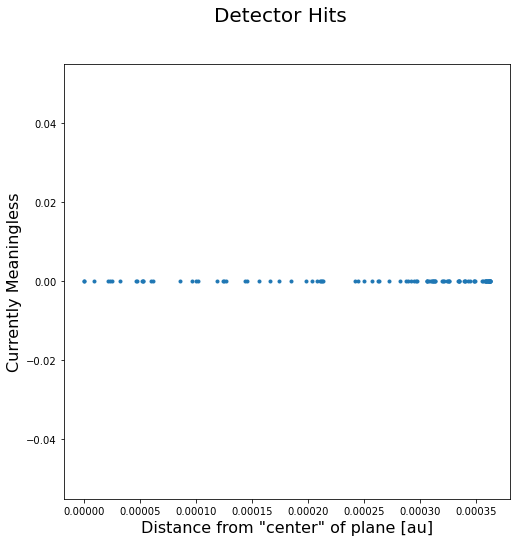

In [25]:
distanceArray = []
for point in hitVector:
    distanceArray.append(distance(point,plane[0]))

zeroArray = np.zeros(np.shape(distanceArray))

fig2 = plt.figure(figsize = (8,8))
plt.plot(distanceArray,zeroArray,'.')
plt.xlabel('Distance from "center" of plane [au]',size = 16)
plt.ylabel('Currently Meaningless', size = 16)
plt.suptitle('Detector Hits', size = 20)

In [101]:
print (km2au(0.04))

2.67384e-10


## Incorporating The Energy Spectrum

### Known Issues

1. I don't know how MeVs plays into this. When I code the energy spectrum, I am going to input a number, but I don't know how to make the units of that number play nice with the units we have.

I think the way to do this is to assume we have a set of initial conditions (our dataframe) and then from each location in our set of inital conditions, launch the spectrum from the sun.

### Single Initial Condition

In [26]:
IC1 = [rHalf,np.pi/2,0,1,0,0,0,0]
IC2 = [rHalf,np.pi/2,np.pi/2,1,0,0,0,0]
IC3 = [rHalf,np.pi/2,np.pi,1,0,0,0,0]
energySpectrum = np.linspace(1,1,10)

In [27]:
columns = ['r','theta','phi','vr','vTheta','vPhi','L','cosBeta']
data = [IC2,IC1,IC3]
testDF = pd.DataFrame(data,columns=columns)
# testDF = testDF.append(data,ignore_index = True)
# appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi,'L':0,'cosBeta':0})
# dataDFSph = dataDFSph.append(appendThis,ignore_index=True)
print (testDF)

          r     theta       phi  vr  vTheta  vPhi  L  cosBeta
0  0.002325  1.570796  1.570796   1       0     0  0        0
1  0.002325  1.570796  0.000000   1       0     0  0        0
2  0.002325  1.570796  3.141593   1       0     0  0        0


In [28]:
q,m = 1,np.mean(energySpectrum)
dt = 0.01
planePos, planeVel, planeCon = determineDetectorPlane(testDF,q,m,dt,True)
plane = [planePos,planeVel]
print ('Location,normal',plane[0],plane[1])
print ('Condition (Spherical)',planeCon)
print ('Complete')

<ipython-input-10-d4ab57578d75>:440: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-d4ab57578d75>:441: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Plane distance: 1.0001188189330952 au
Location,normal [0.4981081135156715, 0.867251958333902, 0.0] [-0.49810811 -0.86725196 -0.        ]
Condition (Spherical) [0.00232524 1.57079633 1.57079633 1.         0.         0.        ]
Complete


In [30]:
testDF1 = updateVelocities(testDF,planeCon)
print (testDF)
print (testDF1.head(5))

          r     theta       phi  vr  vTheta  vPhi  L  cosBeta
0  0.002325  1.570796  1.570796   1       0     0  0        0
1  0.002325  1.570796  0.000000   1       0     0  0        0
2  0.002325  1.570796  3.141593   1       0     0  0        0
          x         y    z  vx   vy  vz    L  cosBeta
0  0.000000  0.002325  0.0   0  1.0   0  0.0      0.0
1  0.002325  0.000000  0.0   0  1.0   0  0.0      0.0
2 -0.002325  0.000000  0.0   0  1.0   0  0.0      0.0


In [33]:
help(trajectoryHit)

Help on function trajectoryHit in module __main__:

trajectoryHit(InitialCondition, plane, q, m, dt, cartesian=True)
    InitialCondition must be given in spherical coordinates. 
    It is then converted to cartesian within this function.
    
    plane: tuple of [p0,n], the point and normal of the plane



In [36]:
# def makeHitDictionary(ICDF,energySpectrum,q,dt,cartesian = True):
    
#     meanEnergy = np.mean(energySpectrum)
#     planePos, planeVel, planeCon = determineDetectorPlane(ICDF,q,meanEnergy,dt,True)
#     plane = [planePos,planeVel]
    
#     ICDFUpdate = updateVelocities(ICDF,planeCon)
    
hitVector = []
hitDictionary = itterativeDict()
# for row in range(0,(ICDFUpdate.shape[0])):
for row in range(0,(testDF.shape[0])):
    for energy in energySpectrum:
#         ICCar = np.asarray(ICDFUpdate.iloc[row][0:6])
        ICCar = np.asarray(testDF1.iloc[row][0:6])

#         hitLocation = trajectoryHit(ICDFUpdate,plane,q,energy,dt,cartesian = True)
        hitLocation = trajectoryHit(ICCar,plane,q,energy,dt,cartesian = True)

        planeHitCheck(plane,hitLocation)
        hitVector.append(hitLocation)
        key = energy
        value = hitVector
        hitDictionary.update(key,value)
# return hitDictionary

# hitDictionary = makeHitDictionary(testDF,energySpectrum,q,dt,True)

print ('Complete')

Complete


3


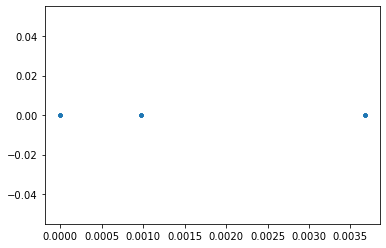

In [35]:
# fig = plt.figure(figsize = (8,8))
distanceArray = []
for key in hitDictionary:
    hitVector = hitDictionary[key]
    for i in range(np.shape(hitVector)[0]):
        point = hitVector[i]
        distanceArray.append(distance(point,plane[0]))

# print (distanceArray)
print (len(np.unique(np.asarray(distanceArray))))
zeroArray = np.zeros(np.shape(distanceArray)[0])
plt.plot(distanceArray,zeroArray,'.')

incorporate the "minimized loss" dataframe generation into this preceeding anything about energy.

assuming parallel velocities point towards earth and a detector of a given size (order 10m), how much of the sun hits it?

store data in master dictionary with energies as keys and values as [x,y,z] tuples.

In [83]:
condition = 0
hitVect = []

for key in (hitDictionary.keys()):
    print (key)

1e-05
11111.11112
22222.22223
33333.333340000005
44444.44445
55555.55556
66666.66667
77777.77778
88888.88889
100000.0


In [70]:
class itterativeDict(dict):
    def __init__(self):
        self = dict()
        
    def update(self,key,value):
        self[key] = value

         

In [75]:
def plotEnergy(hitDictionary,condition):
    '''
    Plots hits from a single initial conditions conrresponding to all energies
    '''
    hitVect = []
    for key in hitDictionary:
        hits = hitDictionary[key][condition]
        


[0.49810811 0.86725196 0.        ]
[0.49810811 0.86725196 0.        ]
[0.49810811 0.86725196 0.        ]
[0.49810811 0.86725196 0.        ]
[0.49810811 0.86725196 0.        ]
[0.49810811 0.86725196 0.        ]
[0.49810811 0.86725196 0.        ]
[0.49810811 0.86725196 0.        ]
[0.49810811 0.86725196 0.        ]
[0.49810811 0.86725196 0.        ]
